In [318]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [319]:
import tomllib
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config


{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': 'WhatsApp_chat.txt',
 'current': 'whatsapp-20240916-104455.parq'}

In [320]:
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")

Lets load the data

In [330]:
df = pd.read_parquet(datafile)
df

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek,year-week
0,2018-12-11 11:21:00,hoi,effervescent-camel,False,True,6,False,worktimes,11:21:00,1,NL,2018-12-11,50,2018-50
1,2018-12-11 11:21:00,kijk wat ik heb gevonden,effervescent-camel,False,True,27,False,worktimes,11:21:00,1,NL,2018-12-11,50,2018-50
2,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50
3,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50
4,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,2024-07-04 03:20:00,verder alles goed!,effervescent-camel,False,True,21,False,night,03:20:00,3,NL,2024-07-04,27,2024-27
5145,2024-07-04 07:25:00,https://www.udinetoday.it/cronaca/navetta-grat...,nimble-wombat,False,True,64,True,morning,07:25:00,3,Non-verbal,2024-07-04,27,2024-27
5146,2024-07-04 13:59:00,<media weggelaten>,hilarious-goldfinch,False,True,21,False,worktimes,13:59:00,3,Non-verbal,2024-07-04,27,2024-27
5147,2024-07-04 14:14:00,<media weggelaten>,nimble-wombat,False,True,21,False,worktimes,14:14:00,3,Non-verbal,2024-07-04,27,2024-27


Let's extract some more info from the timestamp:

In [355]:
df["date"] = df["timestamp"].dt.date
df["isoweek"] = df["timestamp"].dt.isocalendar().week
df["year-week"] = df["timestamp"].dt.strftime("%Y-%W")
df.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek,year-week
0,2018-12-11 11:21:00,hoi,effervescent-camel,False,True,6,False,worktimes,11:21:00,1,NL,2018-12-11,50,2018-50
1,2018-12-11 11:21:00,kijk wat ik heb gevonden,effervescent-camel,False,True,27,False,worktimes,11:21:00,1,NL,2018-12-11,50,2018-50
2,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50
3,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50
4,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50


In [356]:
topk = list(df[df["is_topk"]].author.unique())
topk

['effervescent-camel',
 'nimble-wombat',
 'hilarious-goldfinch',
 'spangled-rabbit']

Now, we can group by the isoweeks, for example. 
Let's reindex in order to fill the missing weeks.

In [357]:
df = df.drop(index=[0])

In [358]:
p = df.groupby("year-week").count()
p.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek
year-week,,,,,,,,,,,,,
2018-50,6,6,6,6,6,6,6,6,6,6,6,6,6
2019-06,2,2,2,2,2,2,2,2,2,2,2,2,2
2019-10,14,14,14,14,14,14,14,14,14,14,14,14,14
2019-11,2,2,2,2,2,2,2,2,2,2,2,2,2
2019-12,15,15,15,15,15,15,15,15,15,15,15,15,15


In [359]:
min_ts = df["timestamp"].min()
max_ts = df["timestamp"].max()
new_index = pd.date_range(start=min_ts, end=max_ts, freq='W', name="year-week").strftime('%Y-%W')
p = p.reindex(new_index, fill_value=0)
p.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek
year-week,,,,,,,,,,,,,
2018-50,6,6,6,6,6,6,6,6,6,6,6,6,6
2018-51,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-52,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-00,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-01,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Messages over time')

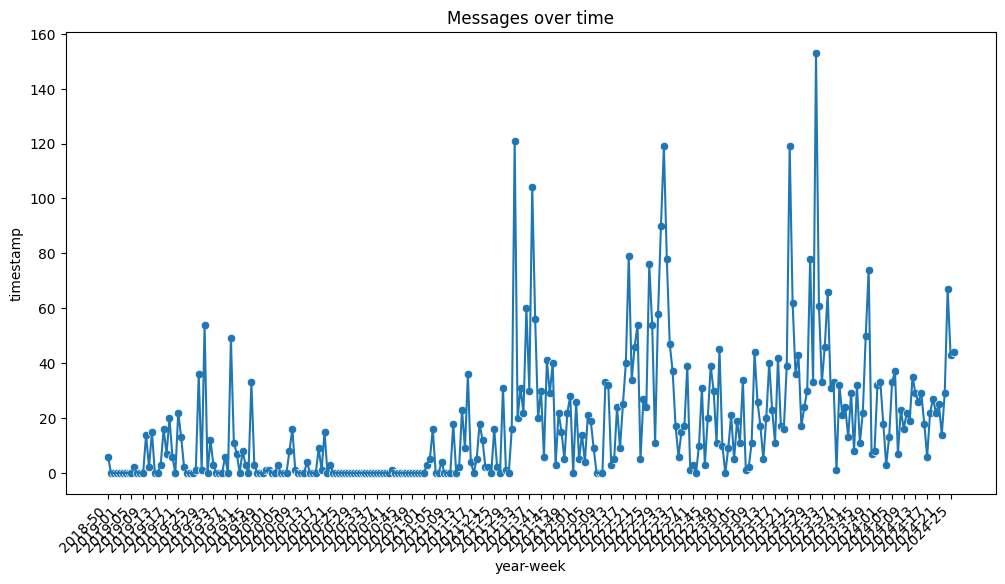

In [360]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=p, x=p.index, y="timestamp", ax=ax)
p["moving_avg"] = p["timestamp"].rolling(window=1).mean()
sns.lineplot(data=p, x=p.index, y="moving_avg", ax=ax)

interval = 4
xticks = p.index[::interval]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha='right');
plt.title("Messages over time")


Try to play with the colors. Make sure adding colors conveys a message, and isnt randomly adding colors.
Probaly, a scatterplot and lineplot are not the best way to show the count of messages per author, per week, for your data, so you might need to modify that. It might not even be useful for your data to do this (eg because you have too many authors).

The main goal here is to find some way to visualise the count over time, per author, and to give you some starting point if that is relevant for your dataset.

In [361]:
# keep only topk authors

p = df[df["author"].isin(topk)].groupby(["author", "year-week"]).count()
# p = df.groupby(["author", "year-week"]).count()
p

timestamp  message  has_emoji  is_topk  \
author             year-week                                           
effervescent-camel 2018-50            5        5          5        5   
                   2019-06            1        1          1        1   
                   2019-10            5        5          5        5   
                   2019-11            1        1          1        1   
                   2019-12            7        7          7        7   
...                                 ...      ...        ...      ...   
spangled-rabbit    2024-21            1        1          1        1   
                   2024-22            2        2          2        2   
                   2024-23            1        1          1        1   
                   2024-25            2        2          2        2   
                   2024-26            4        4          4        4   

                              message_length  has_link  timestamp_category  \
author             year-week                                                 
effervescent-camel 2018-50                 5         5                   5   
                   2019-06                 1         1                   1   
                   2019-10                 5         5                   5   
                   2019-11                 1         1                   1   
                   2019-12                 7         7                   7   
...                                      ...       ...                 ...   
spangled-rabbit    2024-21                 1         1                   1   
                   2024-22                 2         2                   2   
                   2024-23                 1         1                   1   
                   2024-25                 2         2                   2   
                   2024-26                 4         4                   4   

                              hour  day_of_week  language  date  isoweek  
author             year-week                                              
effervescent-camel 2018-50       5            5         5     5        5  
                   2019-06       1            1         1     1        1  
                   2019-10       5            5         5     5        5  
                   2019-11       1            1         1     1        1  
                   2019-12       7            7         7     7        7  
...                            ...          ...       ...   ...      ...  
spangled-rabbit    2024-21       1            1         1     1        1  
                   2024-22       2            2         2     2        2  
                   2024-23       1            1         1     1        1  
                   2024-25       2            2         2     2        2  
                   2024-26       4            4         4     4        4  

[642 rows x 12 columns]

In [362]:
# authors = df["author"].unique()
multi_index = pd.MultiIndex.from_product([topk, new_index], names=["author", "year-week"])
p = p.reindex(multi_index, fill_value=0)
p

timestamp  message  has_emoji  is_topk  \
author             year-week                                           
effervescent-camel 2018-50            5        5          5        5   
                   2018-51            0        0          0        0   
                   2018-52            0        0          0        0   
                   2019-00            0        0          0        0   
                   2019-01            0        0          0        0   
...                                 ...      ...        ...      ...   
spangled-rabbit    2024-22            2        2          2        2   
                   2024-23            1        1          1        1   
                   2024-24            0        0          0        0   
                   2024-25            2        2          2        2   
                   2024-26            4        4          4        4   

                              message_length  has_link  timestamp_category  \
author             year-week                                                 
effervescent-camel 2018-50                 5         5                   5   
                   2018-51                 0         0                   0   
                   2018-52                 0         0                   0   
                   2019-00                 0         0                   0   
                   2019-01                 0         0                   0   
...                                      ...       ...                 ...   
spangled-rabbit    2024-22                 2         2                   2   
                   2024-23                 1         1                   1   
                   2024-24                 0         0                   0   
                   2024-25                 2         2                   2   
                   2024-26                 4         4                   4   

                              hour  day_of_week  language  date  isoweek  
author             year-week                                              
effervescent-camel 2018-50       5            5         5     5        5  
                   2018-51       0            0         0     0        0  
                   2018-52       0            0         0     0        0  
                   2019-00       0            0         0     0        0  
                   2019-01       0            0         0     0        0  
...                            ...          ...       ...   ...      ...  
spangled-rabbit    2024-22       2            2         2     2        2  
                   2024-23       1            1         1     1        1  
                   2024-24       0            0         0     0        0  
                   2024-25       2            2         2     2        2  
                   2024-26       4            4         4     4        4  

[1160 rows x 12 columns]

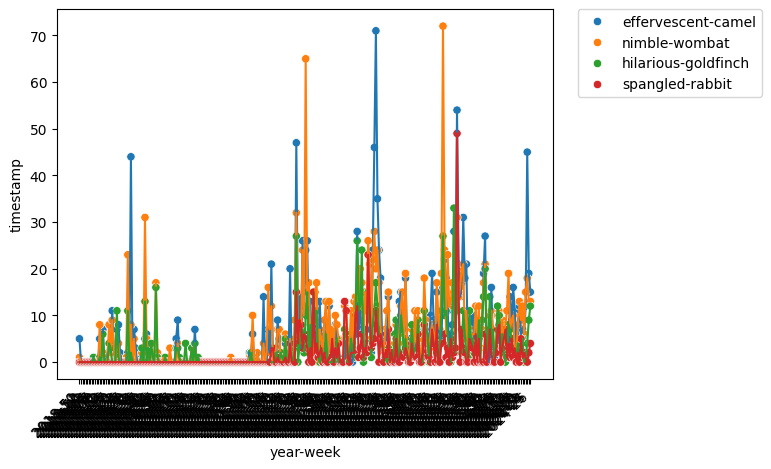

In [363]:
# put legend outside the plot
sns.scatterplot(data=p, x="year-week", y="timestamp", hue="author", legend=True)
sns.lineplot(data=p, x="year-week", y="timestamp", legend=False, hue="author")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45, ha='right');

In [364]:
df["day_of_week"] = df["timestamp"].dt.day_name()
df_agg = df.groupby(['date', 'day_of_week']).size().reset_index(name='message_count')
df_agg

,date,day_of_week,message_count
0,2018-12-11,Tuesday,6
1,2019-02-14,Thursday,2
2,2019-03-16,Saturday,13
3,2019-03-17,Sunday,1
4,2019-03-22,Friday,1
...,...,...,...
696,2024-06-30,Sunday,7
697,2024-07-01,Monday,1
698,2024-07-02,Tuesday,17
699,2024-07-03,Wednesday,5


Sometimes, you want to group the timeseries in clusters, eg per day of the week (of per month, or per year, etc).
Facetgrid is a nice way to do this.

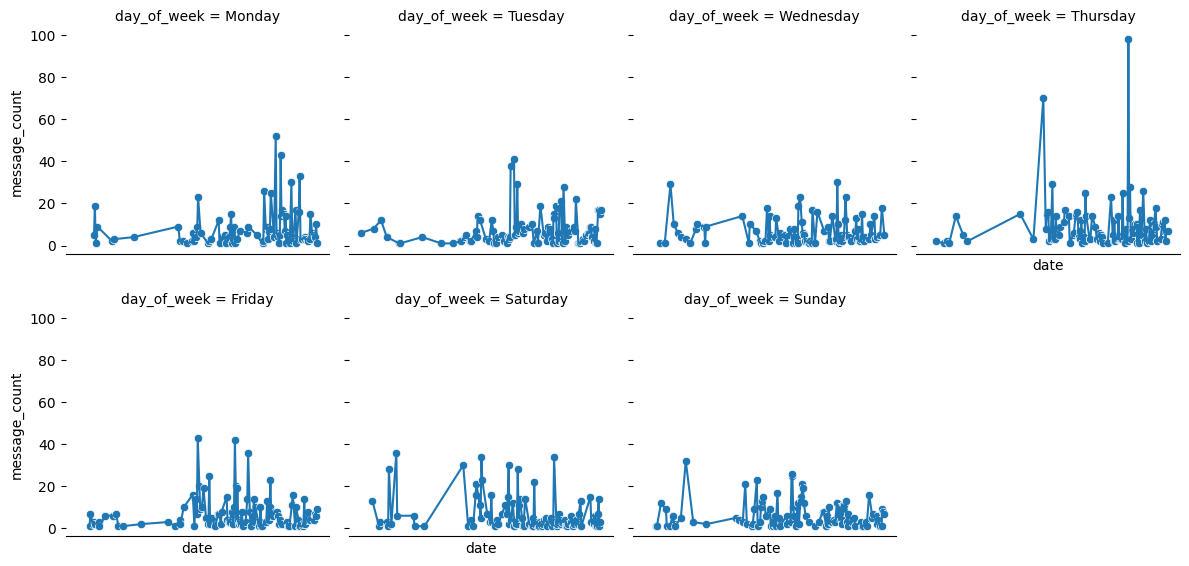

In [365]:
# Set the order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a FacetGrid to plot the line plots for each day of the week
g = sns.FacetGrid(df_agg, col='day_of_week', col_wrap=4, height=3, col_order=days_order)
g.map(sns.scatterplot, 'date', 'message_count')
g.map(sns.lineplot, 'date', 'message_count')
g.set(xticks=[])
g.despine(left=True, bottom=False)

Another nice plot is the area plot. Plotly has a nice version if this one.

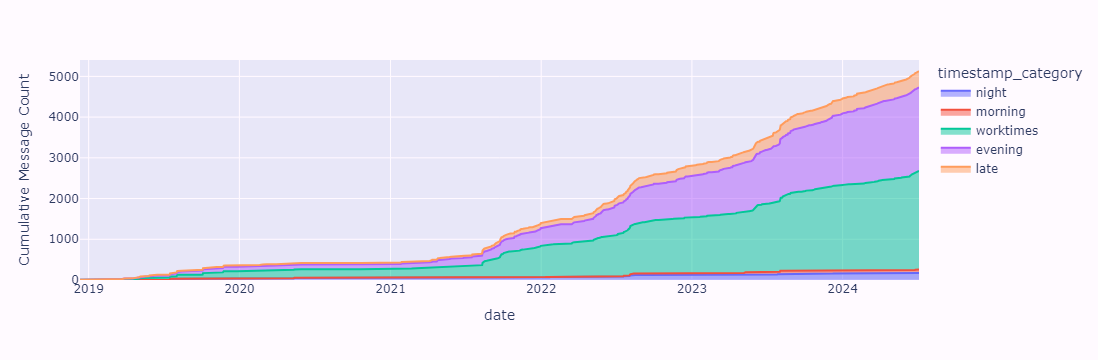

In [366]:
import plotly.express as px
# first count the number for every category, for every date
p = df.groupby(["date", "timestamp_category"]).size().reset_index(name='message_count')
# then, make the count cumulative for every category
p['cumulative_count'] = p.groupby('timestamp_category')['message_count'].cumsum()

fig = px.area(p, x="date", y="cumulative_count", color="timestamp_category",
              line_group="timestamp_category", labels={"cumulative_count": "Cumulative Message Count"})
fig.show()

# Code for two authors

I have experimented with two authors, and explored the question "who is the first (or last) of the day to send a message?".
I didnt tweak this for groupchats.

In [367]:
df_grouped = df.groupby('date').agg({
    'timestamp': ['min', 'max'],
    'author': ['first', 'last'],
    })
df_grouped.columns = df_grouped.columns.map("_".join)
df_grouped

,timestamp_min,timestamp_max,author_first,author_last
date,,,,
2018-12-11,2018-12-11 11:21:00,2018-12-11 11:48:00,effervescent-camel,nimble-wombat
2019-02-14,2019-02-14 18:40:00,2019-02-14 18:52:00,effervescent-camel,hilarious-goldfinch
2019-03-16,2019-03-16 20:01:00,2019-03-16 20:10:00,nimble-wombat,nimble-wombat
2019-03-17,2019-03-17 10:15:00,2019-03-17 10:15:00,hilarious-goldfinch,hilarious-goldfinch
2019-03-22,2019-03-22 11:37:00,2019-03-22 11:37:00,nimble-wombat,nimble-wombat
...,...,...,...,...
2024-06-30,2024-06-30 05:07:00,2024-06-30 15:59:00,effervescent-camel,nimble-wombat
2024-07-01,2024-07-01 16:43:00,2024-07-01 16:43:00,effervescent-camel,effervescent-camel
2024-07-02,2024-07-02 08:37:00,2024-07-02 19:34:00,effervescent-camel,nimble-wombat


In [368]:
df_grouped['timestamp_max_shifted'] = df_grouped['timestamp_max'].shift()

# Calculate the time difference
df_grouped['time_difference'] = df_grouped['timestamp_min'] - df_grouped['timestamp_max_shifted']
df_grouped

,timestamp_min,timestamp_max,author_first,author_last,timestamp_max_shifted,time_difference
date,,,,,,
2018-12-11,2018-12-11 11:21:00,2018-12-11 11:48:00,effervescent-camel,nimble-wombat,NaT,NaT
2019-02-14,2019-02-14 18:40:00,2019-02-14 18:52:00,effervescent-camel,hilarious-goldfinch,2018-12-11 11:48:00,65 days 06:52:00
2019-03-16,2019-03-16 20:01:00,2019-03-16 20:10:00,nimble-wombat,nimble-wombat,2019-02-14 18:52:00,30 days 01:09:00
2019-03-17,2019-03-17 10:15:00,2019-03-17 10:15:00,hilarious-goldfinch,hilarious-goldfinch,2019-03-16 20:10:00,0 days 14:05:00
2019-03-22,2019-03-22 11:37:00,2019-03-22 11:37:00,nimble-wombat,nimble-wombat,2019-03-17 10:15:00,5 days 01:22:00
...,...,...,...,...,...,...
2024-06-30,2024-06-30 05:07:00,2024-06-30 15:59:00,effervescent-camel,nimble-wombat,2024-06-29 20:05:00,0 days 09:02:00
2024-07-01,2024-07-01 16:43:00,2024-07-01 16:43:00,effervescent-camel,effervescent-camel,2024-06-30 15:59:00,1 days 00:44:00
2024-07-02,2024-07-02 08:37:00,2024-07-02 19:34:00,effervescent-camel,nimble-wombat,2024-07-01 16:43:00,0 days 15:54:00


Text(0.5, 1.0, 'nimble-wombat +, effervescent-camel -')

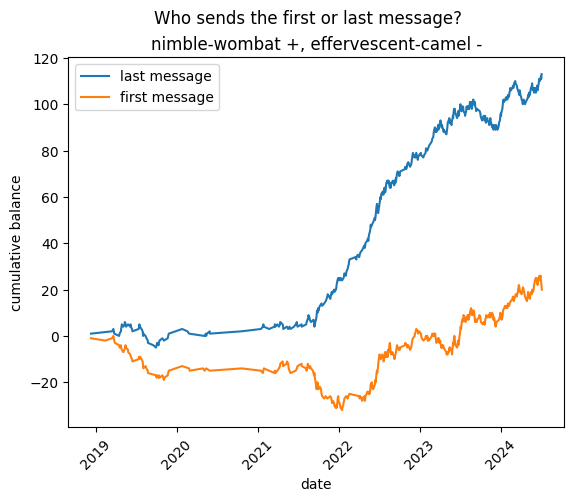

In [369]:
# this only works with two authors
mapping = {'nimble-wombat': 1, 'effervescent-camel' : -1}
df_grouped['last_message'] = df_grouped['author_last'].map(mapping)
df_grouped['first_message'] = df_grouped['author_first'].map(mapping)
df_grouped["last_balance"] = df_grouped['last_message'].cumsum()
df_grouped["first_balance"] = df_grouped['first_message'].cumsum()

sns.lineplot(data=df_grouped, x='date', y='last_balance', label="last message")
sns.lineplot(data=df_grouped, x='date', y='first_balance', label="first message")
plt.xticks(rotation=45);
plt.ylabel("cumulative balance")
plt.suptitle("Who sends the first or last message?")
plt.title("nimble-wombat +, effervescent-camel -")


In [370]:
df_grouped.head()

,timestamp_min,timestamp_max,author_first,author_last,timestamp_max_shifted,time_difference,last_message,first_message,last_balance,first_balance
date,,,,,,,,,,
2018-12-11,2018-12-11 11:21:00,2018-12-11 11:48:00,effervescent-camel,nimble-wombat,NaT,NaT,1.0,-1.0,1.0,-1.0
2019-02-14,2019-02-14 18:40:00,2019-02-14 18:52:00,effervescent-camel,hilarious-goldfinch,2018-12-11 11:48:00,65 days 06:52:00,NaN,-1.0,NaN,-2.0
2019-03-16,2019-03-16 20:01:00,2019-03-16 20:10:00,nimble-wombat,nimble-wombat,2019-02-14 18:52:00,30 days 01:09:00,1.0,1.0,2.0,-1.0
2019-03-17,2019-03-17 10:15:00,2019-03-17 10:15:00,hilarious-goldfinch,hilarious-goldfinch,2019-03-16 20:10:00,0 days 14:05:00,NaN,NaN,NaN,NaN
2019-03-22,2019-03-22 11:37:00,2019-03-22 11:37:00,nimble-wombat,nimble-wombat,2019-03-17 10:15:00,5 days 01:22:00,1.0,1.0,3.0,0.0


In [371]:
def time_to_decimal(time_obj):
    return time_obj.hour + time_obj.minute / 60 + time_obj.second / 3600

df_grouped["decimal_first_time"] = df_grouped.timestamp_min.apply(time_to_decimal)
df_grouped["decimal_last_time"] = df_grouped.timestamp_max.apply(time_to_decimal)


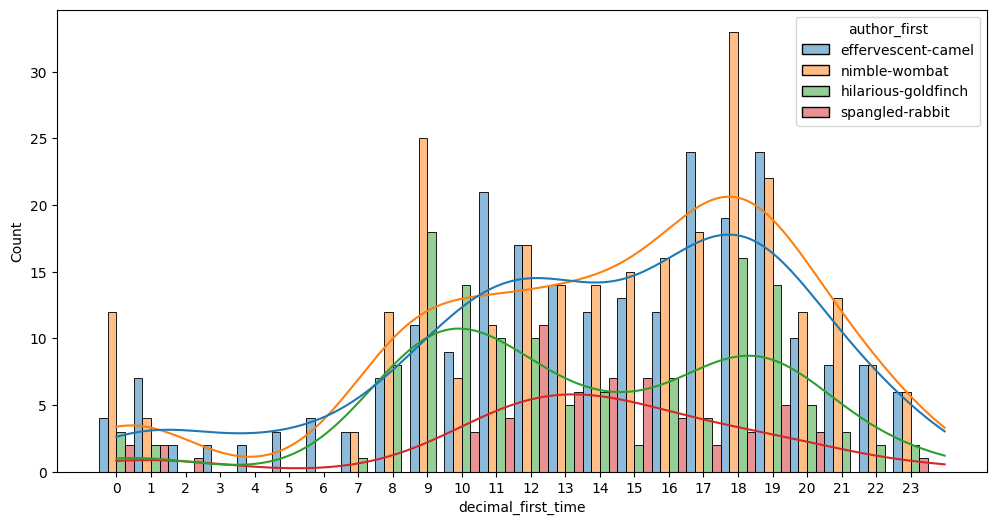

In [372]:

fig, ax = plt.subplots(figsize=(12, 6))
center = [t - 0.5 for t in range(0,25)]
sns.histplot(data=df_grouped,
    x='decimal_first_time',
    hue='author_first',
    common_norm=False,
    fill=True,
    bins=center,
    multiple="dodge",
    kde=True,
    ax=ax)
ax.set_xticks(range(0,24));

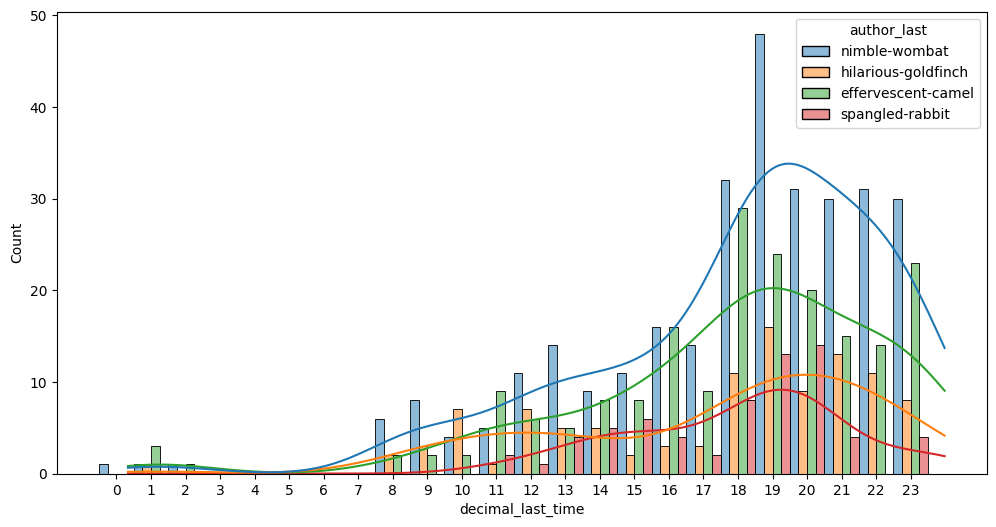

In [373]:
fig, ax = plt.subplots(figsize=(12, 6))
center = [t - 0.5 for t in range(0,25)]
sns.histplot(data=df_grouped,
    x='decimal_last_time',
    hue='author_last',
    common_norm=False,
    fill=True,
    bins=center,
    multiple="dodge",
    kde=True,
    ax=ax)
ax.set_xticks(range(0,24));

In [374]:
import numpy as np
def decimal_delta(td):
    if td == 0:
        return 0
    return td.total_seconds() / 3600

df["next_author"] = df.author.shift(-1)
df["next_timestamp"] = df.timestamp.shift(-1)
df["reaction_time"] = df.next_timestamp - df.timestamp
df["decimal_reaction_time"] = df.reaction_time.apply(decimal_delta)
df["reply"] = df.apply(lambda x: x.author != x.next_author, axis=1)
df.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek,year-week,next_author,next_timestamp,reaction_time,decimal_reaction_time,reply
1,2018-12-11 11:21:00,kijk wat ik heb gevonden,effervescent-camel,False,True,27,False,worktimes,11:21:00,Tuesday,NL,2018-12-11,50,2018-50,effervescent-camel,2018-12-11 11:21:00,0 days 00:00:00,0.000000,False
2,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,Tuesday,Non-verbal,2018-12-11,50,2018-50,effervescent-camel,2018-12-11 11:21:00,0 days 00:00:00,0.000000,False
3,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,Tuesday,Non-verbal,2018-12-11,50,2018-50,effervescent-camel,2018-12-11 11:21:00,0 days 00:00:00,0.000000,False
4,2018-12-11 11:21:00,<media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,Tuesday,Non-verbal,2018-12-11,50,2018-50,effervescent-camel,2018-12-11 11:22:00,0 days 00:01:00,0.016667,False
5,2018-12-11 11:22:00,“ze is net een aap” ik moest echt heel hard la...,effervescent-camel,False,True,53,False,worktimes,11:22:00,Tuesday,NL,2018-12-11,50,2018-50,nimble-wombat,2018-12-11 11:48:00,0 days 00:26:00,0.433333,True


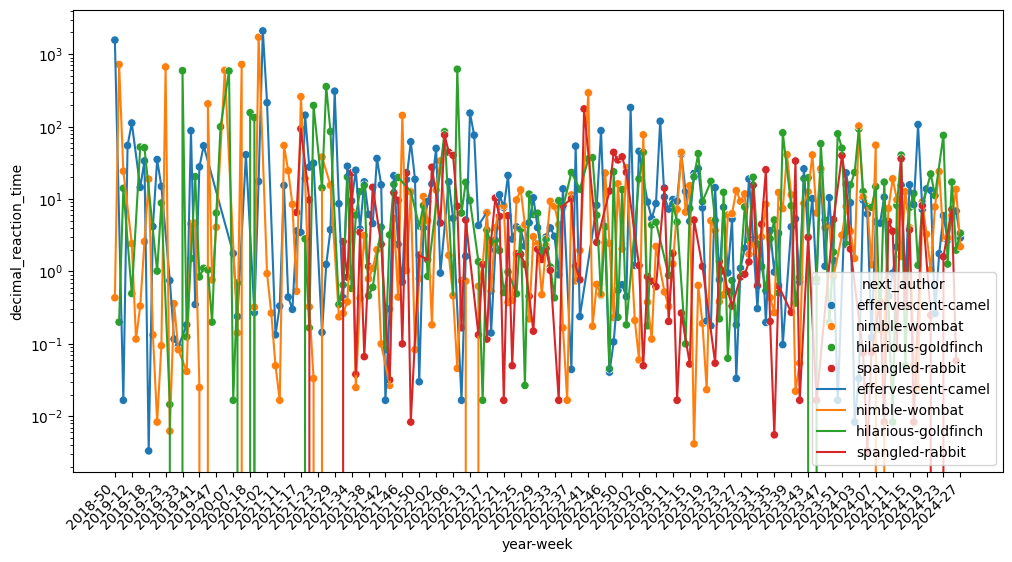

In [375]:
fig, ax = plt.subplots(figsize=(12, 6))
p = df[df.reply].groupby(['year-week', 'next_author']).agg({'decimal_reaction_time': 'mean'})
sns.scatterplot(data=p, x='year-week', y='decimal_reaction_time', hue='next_author', ax=ax)
sns.lineplot(data=p, x='year-week', y='decimal_reaction_time', hue='next_author', ax=ax)
plt.yscale('log')
interval = 4
xticks = p.reset_index()['year-week'].unique()[::interval]
# xticks = p.index[::interval]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=45, ha='right');

(0.0, 24.0)

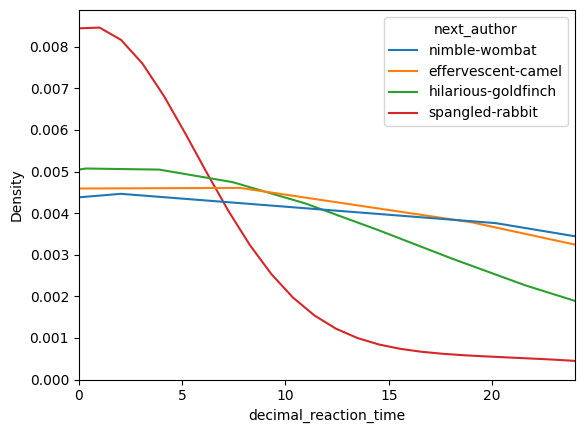

In [376]:
p = df[df.reply]

sns.kdeplot(
    data=p,
    x='decimal_reaction_time',
    hue='next_author'
)
plt.xlim((0,24))
# plt.yscale('log')

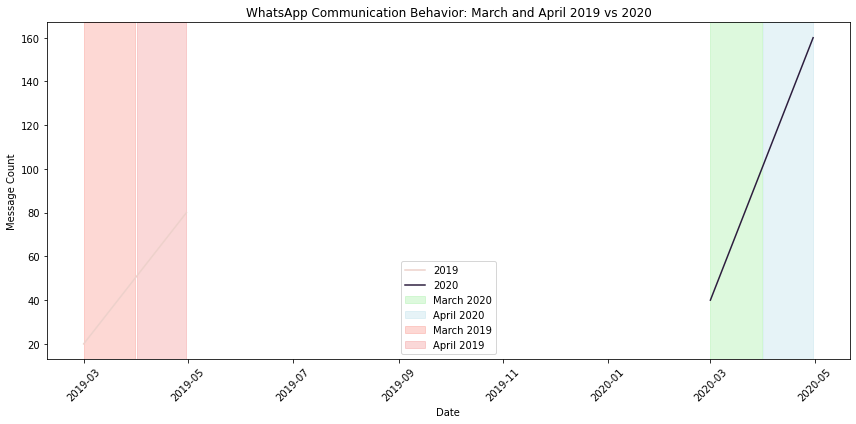

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame setup (replace this with your actual data)
# Create date ranges for March and April of 2019 and 2020
dates_2019 = pd.date_range(start='2019-03-01', end='2019-04-30', freq='D')
dates_2020 = pd.date_range(start='2020-03-01', end='2020-04-30', freq='D')

# Simulated message counts (replace with your actual data)
message_counts_2019 = [20 + i for i in range(len(dates_2019))]  # Simulated increase
message_counts_2020 = [40 + 2*i for i in range(len(dates_2020))]  # Simulated doubling

# Create DataFrames for each year
data_2019 = pd.DataFrame({'date': dates_2019, 'message_count': message_counts_2019})
data_2020 = pd.DataFrame({'date': dates_2020, 'message_count': message_counts_2020})

# Add a year column
data_2019['year'] = 2019
data_2020['year'] = 2020

# Concatenate the DataFrames
data = pd.concat([data_2019, data_2020])

# Set the date as the index
data.set_index('date', inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=data, x=data.index, y='message_count', hue='year', ax=ax)

# Highlight the areas for March and April 2020
ax.axvspan('2020-03-01', '2020-03-31', color='lightgreen', alpha=0.3, label='March 2020')
ax.axvspan('2020-04-01', '2020-04-30', color='lightblue', alpha=0.3, label='April 2020')

# Highlight the areas for March and April 2019
ax.axvspan('2019-03-01', '2019-03-31', color='salmon', alpha=0.3, label='March 2019')
ax.axvspan('2019-04-01', '2019-04-30', color='lightcoral', alpha=0.3, label='April 2019')

# Customize the plot
plt.title("WhatsApp Communication Behavior: March and April 2019 vs 2020")
plt.xlabel("Date")
plt.ylabel("Message Count")
plt.xticks(rotation=45)
ax.legend()

plt.tight_layout()  # Adjust layout
plt.show()


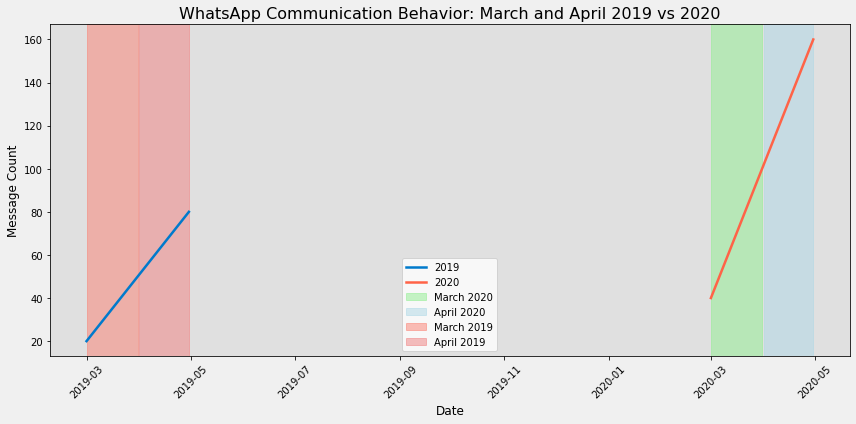

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame setup (replace this with your actual data)
dates_2019 = pd.date_range(start='2019-03-01', end='2019-04-30', freq='D')
dates_2020 = pd.date_range(start='2020-03-01', end='2020-04-30', freq='D')

# Simulated message counts (replace with your actual data)
message_counts_2019 = [20 + i for i in range(len(dates_2019))]  # Simulated increase
message_counts_2020 = [40 + 2*i for i in range(len(dates_2020))]  # Simulated doubling

# Create DataFrames for each year
data_2019 = pd.DataFrame({'date': dates_2019, 'message_count': message_counts_2019})
data_2020 = pd.DataFrame({'date': dates_2020, 'message_count': message_counts_2020})

# Add a year column
data_2019['year'] = 2019
data_2020['year'] = 2020

# Concatenate the DataFrames
data = pd.concat([data_2019, data_2020])

# Set the date as the index
data.set_index('date', inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set background color to gray
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#e0e0e0')

# Plot with thicker lines and different styles
sns.lineplot(data=data, x=data.index, y='message_count', hue='year', ax=ax,
             linewidth=2.5, palette=['#007acc', '#ff6347'], dashes=False)

# Highlight the areas for March and April 2020
ax.axvspan('2020-03-01', '2020-03-31', color='lightgreen', alpha=0.5, label='March 2020')
ax.axvspan('2020-04-01', '2020-04-30', color='lightblue', alpha=0.5, label='April 2020')

# Highlight the areas for March and April 2019
ax.axvspan('2019-03-01', '2019-03-31', color='salmon', alpha=0.5, label='March 2019')
ax.axvspan('2019-04-01', '2019-04-30', color='lightcoral', alpha=0.5, label='April 2019')

# Customize the plot
plt.title("WhatsApp Communication Behavior: March and April 2019 vs 2020", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Message Count", fontsize=12)
plt.xticks(rotation=45)
ax.legend()

plt.tight_layout()  # Adjust layout
plt.show()



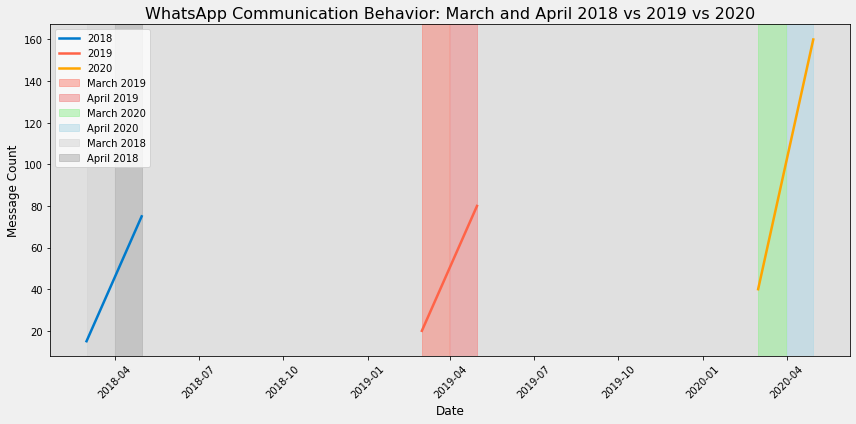

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame setup (replace this with your actual data)
dates_2018 = pd.date_range(start='2018-03-01', end='2018-04-30', freq='D')
dates_2019 = pd.date_range(start='2019-03-01', end='2019-04-30', freq='D')
dates_2020 = pd.date_range(start='2020-03-01', end='2020-04-30', freq='D')

# Simulated message counts (replace with your actual data)
message_counts_2018 = [15 + i for i in range(len(dates_2018))]  # Simulated count for 2018
message_counts_2019 = [20 + i for i in range(len(dates_2019))]  # Simulated increase for 2019
message_counts_2020 = [40 + 2*i for i in range(len(dates_2020))]  # Simulated doubling for 2020

# Create DataFrames for each year
data_2018 = pd.DataFrame({'date': dates_2018, 'message_count': message_counts_2018})
data_2019 = pd.DataFrame({'date': dates_2019, 'message_count': message_counts_2019})
data_2020 = pd.DataFrame({'date': dates_2020, 'message_count': message_counts_2020})

# Add a year column
data_2018['year'] = 2018
data_2019['year'] = 2019
data_2020['year'] = 2020

# Concatenate the DataFrames
data = pd.concat([data_2018, data_2019, data_2020])

# Set the date as the index
data.set_index('date', inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set background color to gray
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#e0e0e0')

# Plot with thicker lines and different styles
sns.lineplot(data=data, x=data.index, y='message_count', hue='year', ax=ax,
             linewidth=2.5, palette=['#007acc', '#ff6347', '#ffa500'])

# Highlight the areas for March and April 2019 and 2020
ax.axvspan('2019-03-01', '2019-03-31', color='salmon', alpha=0.5, label='March 2019')
ax.axvspan('2019-04-01', '2019-04-30', color='lightcoral', alpha=0.5, label='April 2019')
ax.axvspan('2020-03-01', '2020-03-31', color='lightgreen', alpha=0.5, label='March 2020')
ax.axvspan('2020-04-01', '2020-04-30', color='lightblue', alpha=0.5, label='April 2020')

# Highlight the areas for March and April 2018
ax.axvspan('2018-03-01', '2018-03-31', color='lightgray', alpha=0.5, label='March 2018')
ax.axvspan('2018-04-01', '2018-04-30', color='darkgray', alpha=0.5, label='April 2018')

# Customize the plot
plt.title("WhatsApp Communication Behavior: March and April 2018 vs 2019 vs 2020", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Message Count", fontsize=12)
plt.xticks(rotation=45)
ax.legend()

plt.tight_layout()  # Adjust layout
plt.show()


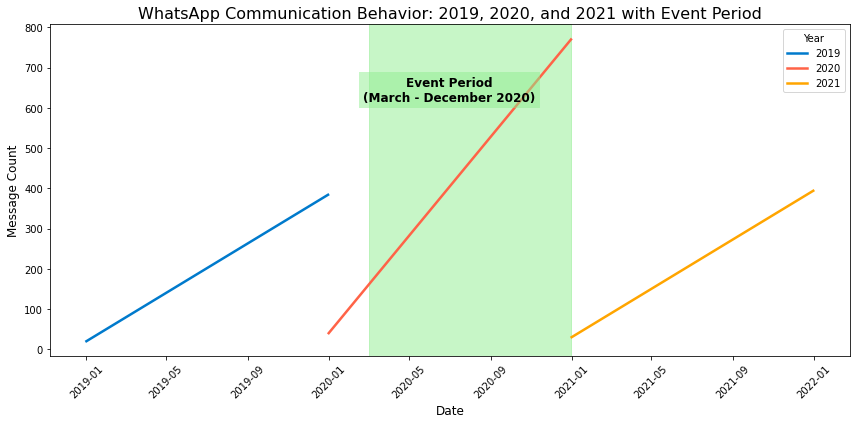

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame setup (replace this with your actual data)
dates_2019 = pd.date_range(start='2019-01-01', end='2019-12-31', freq='D')
dates_2020 = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
dates_2021 = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')

# Simulated message counts (replace with your actual data)
message_counts_2019 = [20 + i for i in range(len(dates_2019))]  # Simulated count for 2019
message_counts_2020 = [40 + 2*i for i in range(len(dates_2020))]  # Simulated increase for 2020
message_counts_2021 = [30 + i for i in range(len(dates_2021))]  # Simulated count for 2021

# Create DataFrames for each year
data_2019 = pd.DataFrame({'date': dates_2019, 'message_count': message_counts_2019})
data_2020 = pd.DataFrame({'date': dates_2020, 'message_count': message_counts_2020})
data_2021 = pd.DataFrame({'date': dates_2021, 'message_count': message_counts_2021})

# Add a year column
data_2019['year'] = 2019
data_2020['year'] = 2020
data_2021['year'] = 2021

# Concatenate the DataFrames
data = pd.concat([data_2019, data_2020, data_2021])

# Set the date as the index
data.set_index('date', inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot with thicker lines and different styles
sns.lineplot(data=data, x=data.index, y='message_count', hue='year', ax=ax,
             linewidth=2.5, palette=['#007acc', '#ff6347', '#ffa500'])

# Highlight the event period from March to December 2020
ax.axvspan('2020-03-01', '2020-12-31', color='lightgreen', alpha=0.5)

# Add a label for the event period
ax.text(pd.Timestamp('2020-07-01'), max(data['message_count']) * 0.8, 'Event Period\n(March - December 2020)',
        horizontalalignment='center', fontsize=12, color='black', weight='bold',
        bbox=dict(facecolor='lightgreen', alpha=0.5, edgecolor='none'))

# Customize the plot
plt.title("WhatsApp Communication Behavior: 2019, 2020, and 2021 with Event Period", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Message Count", fontsize=12)
plt.xticks(rotation=45)
ax.legend(title='Year')

plt.tight_layout()  # Adjust layout
plt.show()



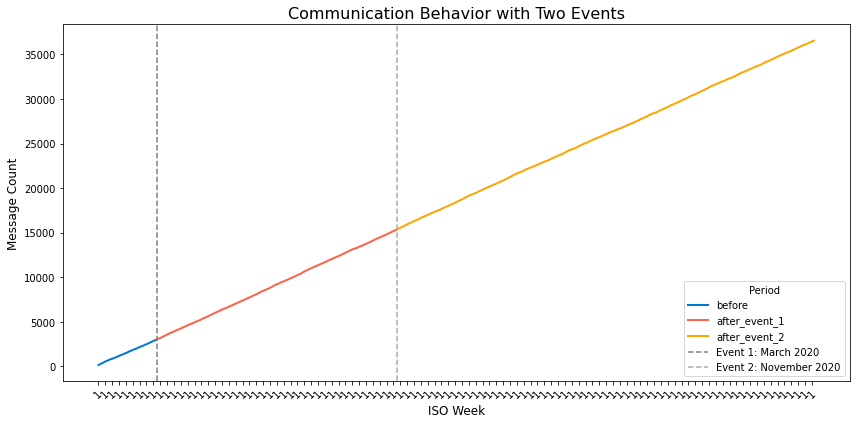

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame setup (replace this with your actual data)
np.random.seed(42)  # For reproducible results
dates = pd.date_range(start='2020-01-01', end='2021-12-31', freq='D')
# Simulated message counts with random fluctuations
message_counts = np.random.normal(loc=50, scale=10, size=len(dates)).cumsum() + 100  # Random walk

# Create a DataFrame
data = pd.DataFrame({'date': dates, 'message_count': message_counts})

# Define event dates
event_date_1 = pd.Timestamp('2020-03-01')
event_date_2 = pd.Timestamp('2020-11-01')

# Create a new column for the color based on the event dates
data['color'] = 'before'
data.loc[data['date'] >= event_date_1, 'color'] = 'after_event_1'
data.loc[data['date'] >= event_date_2, 'color'] = 'after_event_2'

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
sns.lineplot(data=data, x='date', y='message_count', ax=ax, 
             hue='color', palette={'before': '#007acc', 'after_event_1': '#ff6347', 'after_event_2': '#ffa500'}, linewidth=2)

# Highlight the event lines
ax.axvline(event_date_1, color='gray', linestyle='--', label='Event 1: March 2020')
ax.axvline(event_date_2, color='darkgray', linestyle='--', label='Event 2: November 2020')

# Customize the x-ticks to show ISO weeks
ax.set_xticks(data['date'][::7])  # Set x-ticks to every week
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).isocalendar()[1]))

# Customize the plot
plt.title("Communication Behavior with Two Events", fontsize=16)
plt.xlabel("ISO Week", fontsize=12)
plt.ylabel("Message Count", fontsize=12)
plt.xticks(rotation=45)
ax.legend(title='Period')

plt.tight_layout()  # Adjust layout
plt.show()
